In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)



In [ ]:
print(mnist.keys())
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_test.shape)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
(10000, 784)


## Ejercicios

### Ejercicio 1

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

**Hint**: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"weights": ["uniform", "distance"], "n_neighbors": [1,4] }]


knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=2, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)



Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [1, 4],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [ ]:
print(grid_search.best_params_)


NameError: ignored

In [ ]:
from sklearn.model_selection import cross_val_score


def checkAccurayOnTestSet(f_model, f_cv=5):

  l_scores = cross_val_score(f_model, X_test, y_test, f_cv, scoring="accuracy", n_jobs=-1)
  print("\nScores in test set ", l_scores)
  return l_scores

In [ ]:
l_scores = checkAccurayOnTestSet(knn_clf)

In [ ]:
print("Score mean : ", l_scores.mean())
print("Score std : ", l_scores.std())

Score mean :  0.9360023884811998
Score std :  0.018777395747928215


### Ejercicio 2

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.

- You can use the `shift()` function from the scipy.ndimage.interpolation module. 
  - For example, `shift(image, [2, 1], cval=0)` shifts the image 2 pixels down and 1 pixel to the right.

Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. 

Finally, train your best model on this expanded training set and measure its accuracy on the test set.

You should observe that your model performs even better now! This technique of artificially growing the training set is called **data augmentation** or **training set expansion**.

In [ ]:

from scipy.ndimage import shift
import numpy as np


#Image shift function
def shiftImg(f_img, f_dx, f_dy):

  if f_img.shape != (28,28):
    f_img = f_img.reshape(28,28)

  shift(f_img, [f_dx, f_dy], cval=0, output=None)


# Shift all images
l_newData = []

for i in [(1,0), (-1,0), (0, -1), (0, 1)]:
  l_newData.append(X_train.copy())

  #Apply siftImg on l_newData[-1] along rows passing i[0] and i[1] as aditional
  #parameters to shiftImg
  np.apply_along_axis(shiftImg, 1, l_newData[-1], i[0], i[1] )

l_newData.append(X_train)
X_trainAug = np.concatenate(l_newData, axis=0)


print("Plain train data shape ", X_train.shape)
print("Augmented data shape ", X_trainAug.shape)

#Train model
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='uniform', n_jobs=-1)

#New train labels are the same as the old ones but repeated in 4 blocks, for each new 
#block of data of the shifted versions
l_yTrainAug = y_train.copy()
np.tile(l_yTrainAug, (5,1))

knn_clf.fit(X_trainAug, l_yTrainAug)

checkAccurayOnTestSet(knn_clf)



Plain train data shape  (60000, 784)
Augmented data shape  (300000, 784)


ValueError: ignored

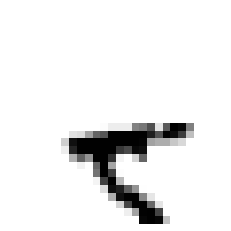

In [ ]:
# Test shift image

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
#plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

l_shiftImg = some_digit_image.copy()
shiftImg(l_shiftImg, 10, 0)
plt.imshow(l_shiftImg, cmap=mpl.cm.binary)

### Ejercicio 3 (optional)

Tackle the Titanic dataset. The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to [Kaggle](https://www.kaggle.com/) and go to the [Titanic challenge](https://www.kaggle.com/c/titanic) to download train.csv and test.csv.

In [ ]:
from google.colab import files
upload = files.upload()

Saving titanic_test.csv to titanic_test.csv
Saving titanic_train.csv to titanic_train.csv


In [ ]:
import pandas as pd
import numpy as np

#Obtain train and test data sets

train_df = pd.read_csv("titanic_train.csv")
test_df = pd.read_csv("titanic_test.csv")


In [ ]:
test_df.columns


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:

# Kaggle does not provide labels of the test set so can only predict
x_train, y_train, x_test = train_df.drop("Survived", axis=1), train_df["Survived"], test_df

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#Train linear SVM
linearSVCParams = [ {"loss": ["hinge", "squared_hinge"], "C": uniform(loc=0, scale=20) } ]
linearSVCModel = LinearSVC()

linearSVCRandSearch = RandomizedSearchCV(linearSVCModel,linearSVCParams, n_jobs=-1, cv=3)
linearSVCRandSearch.fit(x_train, y_train)


#Train radom forest
randomForestParams = [ {"randomState": 0, "criterion": ["gini", "entropy", "log_loss"]} ]
randomForestModel = RandomForestClassifier()

randomForestRandSearch = RandomizedSearchCV(randomForestModel,randomForestParams, n_jobs=-1, cv=3)
randomForestRandSearch.fit(x_train, y_train)


# Train neural net
neuralNetParams = [ {"activation": ["identity", "logistic", "tanh", "relu"], "learning_rate": ["constant", "invscaling", "adaptive"]  } ]
neuralNetModel = MLPClassifier()

neuralNetRandSearch = RandomizedSearchCV(neuralNetModel,neuralNetParams, n_jobs=-1, cv=3, scoring = "f1")
neuralNetRandSearch.fit(x_train, y_train)







In [ ]:
# Check classifiers F1, precision and recall metrics


### Ejercicio 4 (optional)

Build a spam classifier:

- Download examples of spam and ham from [Apache SpamAssassin’s public datasets](https://spamassassin.apache.org/old/publiccorpus/).

- Unzip the datasets and familiarize yourself with the data format.

- Split the datasets into a training set and a test set.

- Write a data preparation pipeline to convert each email into a feature vector.
Your preparation pipeline should transform an email into a (sparse) vector
indicating the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.

- You may want to add hyperparameters to your preparation pipeline to control 
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform *stemming* (i.e., trim off word endings; there are
Python libraries available to do this).

- Then try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.